In [1]:
# data from FoodData Central: https://fdc.nal.usda.gov/
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read subset of food nutrient csv
nutrient = pd.read_csv('./data_csvs/food_nutrient.csv', usecols=['fdc_id', 'nutrient_id', 'amount'])

print('dataframe shape:', nutrient.shape)
nutrient.head()

dataframe shape: (26235966, 3)


,fdc_id,nutrient_id,amount
0,1105904,1257,0.00
1,1105904,1293,53.33
2,1105904,1253,0.00
3,1105904,1092,0.00
4,1105904,1008,867.00


In [3]:
# read subset of nutrient csv
nutrient_id = pd.read_csv('./data_csvs/nutrient.csv', usecols=['id', 'name', 'unit_name'])

print('dataframe shape:', nutrient_id.shape)
nutrient_id.head()

dataframe shape: (477, 3)


,id,name,unit_name
0,2047,Energy (Atwater General Factors),KCAL
1,2048,Energy (Atwater Specific Factors),KCAL
2,1001,Solids,G
3,1002,Nitrogen,G
4,1003,Protein,G


In [4]:
# duplicate id to double check that ids from both tables match
nutrient_id['id2'] = nutrient_id['id']

# join nutrients with nutrient names, etc
food_nutrients = nutrient.join(
    nutrient_id.set_index('id'), on='nutrient_id', how='left')

food_nutrients.head()

,fdc_id,nutrient_id,amount,name,unit_name,id2
0,1105904,1257,0.00,"Fatty acids, total trans",G,1257.0
1,1105904,1293,53.33,"Fatty acids, total polyunsaturated",G,1293.0
2,1105904,1253,0.00,Cholesterol,MG,1253.0
3,1105904,1092,0.00,"Potassium, K",MG,1092.0
4,1105904,1008,867.00,Energy,KCAL,1008.0


In [5]:
# load branded food dataframe
branded_food = pd.read_csv('cleaned_branded_food.csv')

In [6]:
# want nutrients for foods in branded food dataframe
# get fdc ids from food nutrients dataframe that are not in branded food df
bf = set(branded_food['fdc_id'])
fn = set(food_nutrients['fdc_id'])
diff = fn - bf

print("number of fdc ids in food nutrients df that aren't in branded food df:\n", len(diff))

number of fdc ids in food nutrients df that aren't in branded food df:
 806091


In [7]:
# make boolean to indicate fdc ids not in branded food df
keeprows = [True if fdcid not in diff else False for fdcid in food_nutrients['fdc_id']]

# drop fdc ids that aren't also in branded food dataframe
food_nutrients = food_nutrients[keeprows]

print('food nutrients shape after dropping fdc ids: ', food_nutrients.shape)

food nutrients shape after dropping fdc ids:  (15553484, 6)


In [8]:
print('num unique fdc ids:', len(food_nutrients['fdc_id'].unique()))

num unique fdc ids: 1099590


In [9]:
# check for nans after combining nutrient dataframes and dropping fdc ids not in branded food dataframe
food_nutrients.isna().sum()

fdc_id         0
nutrient_id    0
amount         0
name           0
unit_name      0
id2            0
dtype: int64

In [10]:
# check if nutrients have duplicates 
countnutrientid = food_nutrients.groupby('fdc_id')['nutrient_id'].value_counts()
duplicates = countnutrientid[countnutrientid > 1]

print('average number of repetition:', np.mean(duplicates))
duplicates

average number of repetition: 2.0308370044052864


fdc_id   nutrient_id
2456687  1008           2
2456691  1008           2
2456693  1008           2
2456695  1008           2
2456706  1008           2
                       ..
2641370  2000           2
2641422  1079           2
2641423  1079           2
2641427  1162           2
2643369  2000           2
Name: count, Length: 1589, dtype: int64

In [11]:
# check ingredients of some fdc ids with duplicates
# food_nutrients[food_nutrients['fdc_id']==2456687]
# food_nutrients[food_nutrients['fdc_id']==2641378]
food_nutrients[food_nutrients['fdc_id']==2641423]

,fdc_id,nutrient_id,amount,name,unit_name,id2
26002560,2641423,1003,16.07,Protein,G,1003.0
26002561,2641423,1005,3.57,"Carbohydrate, by difference",G,1005.0
26002562,2641423,1004,5.36,Total lipid (fat),G,1004.0
26002563,2641423,1079,0.00,"Fiber, total dietary",G,1079.0
26002564,2641423,2067,0.00,Vitamin A,UG,2067.0
26002565,2641423,1089,0.64,"Iron, Fe",MG,1089.0
26002566,2641423,1258,0.89,"Fatty acids, total saturated",G,1258.0
26002567,2641423,1008,125.00,Energy,KCAL,1008.0
26002568,2641423,1079,0.00,"Fiber, total dietary",G,1079.0
26002569,2641423,1162,26.80,"Vitamin C, total ascorbic acid",MG,1162.0


In [12]:
# duplicate nutrient id entries have the same 'amount' values or low values that look abnormally low
# for duplicate nutrient id entries, keep higher 'amount' value
# iterate through duplicates
idxs_todrop = []
for fdcid, nutid in duplicates.index:
    # matches fdc id
    matchfdc = food_nutrients[food_nutrients['fdc_id']==fdcid]
    # matches fdc id and nutrient id
    matches = matchfdc[matchfdc['nutrient_id']==nutid]
    # list of match indicies
    matchidxs = matches.index
    
    # if amounts all the same, drop all but the first
    if np.mean(matches['amount']) == matches.loc[matchidxs[0], 'amount']:
        todrop = list(matchidxs[1:])
    # else amounts different, keep the highest value
    else:
        # largest value
        largestamt = np.max(matches['amount'])
        todrop = [matchidxs[i] for i in range(len(matchidxs)) if matches.loc[matchidxs[i], 'amount'] < largestamt]
        
    # add indexes to list
    idxs_todrop += todrop

print('num indexs to drop:', len(idxs_todrop))
idxs_todrop[:5]

num indexs to drop: 1638


[23329252, 23329310, 23329327, 23329366, 23329519]

In [13]:
print('original shape: ', food_nutrients.shape)

# drop duplicate nutrient rows
food_nutrients.drop(idxs_todrop, axis=0, inplace=True)

print('duplicates dropped shape:', food_nutrients.shape)

original shape:  (15553484, 6)
duplicates dropped shape: (15551846, 6)


In [14]:
# check if nutrient names have duplicates 
countnutrientid = food_nutrients.groupby('fdc_id')['name'].value_counts()
duplicates = countnutrientid[countnutrientid > 1]

print('average number of repetition:', np.mean(duplicates))
duplicates

average number of repetition: 2.0


fdc_id   name  
398115   Energy    2
454151   Energy    2
559122   Energy    2
1207913  Energy    2
1259053  Energy    2
1499968  Energy    2
1551120  Energy    2
2031320  Energy    2
2062075  Energy    2
2334505  Energy    2
2339503  Energy    2
2439555  Energy    2
Name: count, dtype: int64

In [15]:
# energy given in kJ (nutrient id 1062) as well as kcal (nutrient id 1008)
# only want energy in kcal since this is the unit most people are familiar with
# number of rows with kJ units
np.sum(food_nutrients['nutrient_id']==1062)

15

In [16]:
# list of food fdc ids with energy in both kj and kcal
fdcids = [i[0] for i in duplicates.index]
print('number of fdc ids with energy given in both kcal and kj:', len(fdcids))
fdcids[:5]

number of fdc ids with energy given in both kcal and kj: 12


[398115, 454151, 559122, 1207913, 1259053]

In [17]:
# get indexes of duplicate energy rows with nutrient id 1062
# rows with nutrient id 1062 (energy in kj units)
matchkj = food_nutrients[food_nutrients['nutrient_id']==1062]

# dataframe containing fdc ids of items with energy listed in both kj and kcal
fdcids_ofdupes = pd.DataFrame({'fdc_id': fdcids})
# make dataframe with only duplicate kj energy rows using inner join
duplicatekj = matchkj.join(fdcids_ofdupes.set_index('fdc_id'), on='fdc_id', how='inner')

# get indexes of rows with energy given in kJ
idxs_todrop = duplicatekj.index
idxs_todrop[:10]

Index([ 1918555,  2652792,  4040261,  8649615,  9240967, 11682075, 12350764,
       18126110, 18532080, 21579967],
      dtype='int64')

In [18]:
print('original shape: ', food_nutrients.shape)

# drop duplicate nutrient rows
food_nutrients.drop(idxs_todrop, axis=0, inplace=True)

print('duplicates dropped shape:', food_nutrients.shape)

original shape:  (15551846, 6)
duplicates dropped shape: (15551834, 6)


In [19]:
# check fdc id that used to have duplicate energy to see that energy in kj dropped
food_nutrients[food_nutrients['fdc_id']==2439555]

,fdc_id,nutrient_id,amount,name,unit_name,id2
23089862,2439555,1162,50.00,"Vitamin C, total ascorbic acid",MG,1162.0
23089863,2439555,1005,73.33,"Carbohydrate, by difference",G,1005.0
23089864,2439555,1093,1133.00,"Sodium, Na",MG,1093.0
23089865,2439555,1004,15.00,Total lipid (fat),G,1004.0
23089866,2439555,1257,0.00,"Fatty acids, total trans",G,1257.0
23089867,2439555,1253,17.00,Cholesterol,MG,1253.0
23089868,2439555,1104,0.00,"Vitamin A, IU",IU,1104.0
23089869,2439555,2000,40.00,"Sugars, total including NLEA",G,2000.0
23089870,2439555,1087,67.00,"Calcium, Ca",MG,1087.0
23089871,2439555,1008,467.00,Energy,KCAL,1008.0


In [20]:
# for food items still having energy in kj, convert kj to kcal
# 1 Kilojoule = 0.23900574 Kilocalorie
# bool indicating rows with energy in kj
mask = food_nutrients['nutrient_id']==1062

# update food nutrients dataframe with converted values, units
food_nutrients.loc[mask, 'amount'] = np.round(food_nutrients.loc[mask, 'amount'] * 0.23900574, decimals=2)
food_nutrients.loc[mask, 'unit_name'] = 'KCAL'

In [21]:
# need to clean up ingredient names
print(len(food_nutrients['name'].unique()))
food_nutrients['name'].unique()

103


array(['Total lipid (fat)', 'Carbohydrate, by difference', 'Potassium, K',
       'Cholesterol', 'Fiber, total dietary', 'Iron, Fe',
       'Fatty acids, total trans', 'Protein',
       'Vitamin D (D2 + D3), International Units',
       'Sugars, total including NLEA', 'Fatty acids, total saturated',
       'Energy', 'Calcium, Ca', 'Sodium, Na',
       'Fatty acids, total monounsaturated',
       'Fatty acids, total polyunsaturated',
       'Vitamin C, total ascorbic acid', 'Folic acid', 'Folate, DFE',
       'Riboflavin', 'Thiamin', 'Vitamin A, IU', 'Vitamin B-12',
       'Vitamin B-6', 'Phosphorus, P', 'Manganese, Mn', 'Magnesium, Mg',
       'Niacin', 'Sugars, added', 'Folate, total', 'Selenium, Se',
       'Vitamin E', 'Fiber, soluble', 'Fiber, insoluble',
       'Total sugar alcohols', 'Zinc, Zn', 'Pantothenic acid',
       'Iodine, I', 'Sorbitol', 'Vitamin K (phylloquinone)', 'Copper, Cu',
       'Carbohydrate, other', 'Molybdenum, Mo', 'Chromium, Cr', 'Biotin',
       'Vitamin E 

In [22]:
# check how often each nutrient listed in dataframe
food_nutrients['name'].value_counts()[:25]

name
Protein                                     1092957
Sodium, Na                                  1089019
Carbohydrate, by difference                 1088268
Energy                                      1082916
Total lipid (fat)                           1080409
Sugars, total including NLEA                1063336
Fatty acids, total saturated                 986752
Cholesterol                                  975559
Fiber, total dietary                         970204
Fatty acids, total trans                     963063
Calcium, Ca                                  962584
Iron, Fe                                     958970
Vitamin C, total ascorbic acid               562796
Potassium, K                                 548428
Vitamin A, IU                                513788
Vitamin D (D2 + D3), International Units     360640
Sugars, added                                290633
Fatty acids, total monounsaturated           136583
Fatty acids, total polyunsaturated           136563
Niacin 

In [23]:
food_nutrients.head()

,fdc_id,nutrient_id,amount,name,unit_name,id2
32,1105906,1004,5.31,Total lipid (fat),G,1004.0
33,1105906,1005,6.12,"Carbohydrate, by difference",G,1005.0
34,1105906,1092,65.00,"Potassium, K",MG,1092.0
35,1105906,1253,6.00,Cholesterol,MG,1253.0
36,1105906,1079,0.40,"Fiber, total dietary",G,1079.0


In [24]:
# combine nutrient name and unit name into new column 'nutrient name (units)'
col1 = food_nutrients['name']
col2 = food_nutrients['unit_name']
food_nutrients['nutrient name (units)'] = [f'{i1} ({i2})' for i1, i2 in zip(col1, col2)]

In [25]:
food_nutrients.head()

,fdc_id,nutrient_id,amount,name,unit_name,id2,nutrient name (units)
32,1105906,1004,5.31,Total lipid (fat),G,1004.0,Total lipid (fat) (G)
33,1105906,1005,6.12,"Carbohydrate, by difference",G,1005.0,"Carbohydrate, by difference (G)"
34,1105906,1092,65.00,"Potassium, K",MG,1092.0,"Potassium, K (MG)"
35,1105906,1253,6.00,Cholesterol,MG,1253.0,Cholesterol (MG)
36,1105906,1079,0.40,"Fiber, total dietary",G,1079.0,"Fiber, total dietary (G)"


In [26]:
# prepare to pivot table to show column for each nutrient
reindexed = food_nutrients.set_index(['fdc_id','nutrient name (units)'])
reindexed.head()

nutrient_id  amount  \
fdc_id  nutrient name (units)                                  
1105906 Total lipid (fat) (G)                   1004    5.31   
        Carbohydrate, by difference (G)         1005    6.12   
        Potassium, K (MG)                       1092   65.00   
        Cholesterol (MG)                        1253    6.00   
        Fiber, total dietary (G)                1079    0.40   

                                                                name  \
fdc_id  nutrient name (units)                                          
1105906 Total lipid (fat) (G)                      Total lipid (fat)   
        Carbohydrate, by difference (G)  Carbohydrate, by difference   
        Potassium, K (MG)                               Potassium, K   
        Cholesterol (MG)                                 Cholesterol   
        Fiber, total dietary (G)                Fiber, total dietary   

                                        unit_name     id2  
fdc_id  nutrient name (units)                              
1105906 Total lipid (fat) (G)                   G  1004.0  
        Carbohydrate, by difference (G)         G  1005.0  
        Potassium, K (MG)                      MG  1092.0  
        Cholesterol (MG)                       MG  1253.0  
        Fiber, total dietary (G)                G  1079.0

In [27]:
# reshape dataframe so each nutrient represented by a column
unstacked = reindexed[['amount']].unstack(level=1)
reindexed = None
unstacked.head()

amount                                 \
nutrient name (units) Acetic acid (MG) Alanine (G) Alcohol, ethyl (G)   
fdc_id                                                                  
344604                             NaN         NaN                NaN   
344605                             NaN         NaN                NaN   
344612                             NaN         NaN                NaN   
344613                             NaN         NaN                NaN   
344614                             NaN         NaN                NaN   

                                                                          \
nutrient name (units) Arginine (G) Ash (G) Aspartic acid (G) Biotin (UG)   
fdc_id                                                                     
344604                         NaN     NaN               NaN         NaN   
344605                         NaN     NaN               NaN         NaN   
344612                         NaN     2.8               NaN         NaN   
344613                         NaN     2.8               NaN         NaN   
344614                         NaN     2.9               NaN         NaN   

                                                      \
nutrient name (units) Caffeine (MG) Calcium, Ca (MG)   
fdc_id                                                 
344604                          NaN             13.0   
344605                          NaN             16.0   
344612                          NaN            135.0   
344613                          NaN            135.0   
344614                          NaN             57.0   

                                                       ...  \
nutrient name (units) Carbohydrate, by difference (G)  ...   
fdc_id                                                 ...   
344604                                           4.07  ...   
344605                                           4.07  ...   
344612                                          57.00  ...   
344613                                          57.00  ...   
344614                                          60.10  ...   

                                                        \
nutrient name (units) Vitamin D2 (ergocalciferol) (UG)   
fdc_id                                                   
344604                                             NaN   
344605                                             NaN   
344612                                             NaN   
344613                                             NaN   
344614                                             NaN   

                                                                        \
nutrient name (units) Vitamin D3 (cholecalciferol) (UG) Vitamin E (MG)   
fdc_id                                                                   
344604                                              NaN            NaN   
344605                                              NaN            NaN   
344612                                              NaN            NaN   
344613                                              NaN            NaN   
344614                                              NaN            NaN   

                                                                            \
nutrient name (units) Vitamin E (MG_ATE) Vitamin E (alpha-tocopherol) (MG)   
fdc_id                                                                       
344604                               NaN                               NaN   
344605                               NaN                               NaN   
344612                               NaN                               NaN   
344613                               NaN                               NaN   
344614                               NaN                               NaN   

                                                              \
nutrient name (units) Vitamin E (label entry primarily) (IU)   
fdc_id                                                         
344604           

In [28]:
# reorganize column names to remove multi-index
unstacked.columns = unstacked.columns.map(lambda x: x[1])
print(unstacked.columns)

Index(['Acetic acid (MG)', 'Alanine (G)', 'Alcohol, ethyl (G)', 'Arginine (G)',
       'Ash (G)', 'Aspartic acid (G)', 'Biotin (UG)', 'Caffeine (MG)',
       'Calcium, Ca (MG)', 'Carbohydrate, by difference (G)',
       ...
       'Vitamin D2 (ergocalciferol) (UG)', 'Vitamin D3 (cholecalciferol) (UG)',
       'Vitamin E (MG)', 'Vitamin E (MG_ATE)',
       'Vitamin E (alpha-tocopherol) (MG)',
       'Vitamin E (label entry primarily) (IU)',
       'Vitamin K (phylloquinone) (UG)', 'Water (G)', 'Xylitol (G)',
       'Zinc, Zn (MG)'],
      dtype='object', length=104)


In [29]:
# only want to keep subset of nutrients
# interested in calories, carbohydrate, protein, fat, fiber, sugar, sodium, cholesterol, iron, vitamin d
nutrients_subset = ['Calcium, Ca (MG)', 'Carbohydrate, by difference (G)', 'Carbohydrate, other (G)', 
 'Cholesterol (MG)','Energy (KCAL)', 'Fatty acids, total monounsaturated (G)', 'Fatty acids, total polyunsaturated (G)', 
 'Fatty acids, total saturated (G)', 'Fatty acids, total trans (G)',  
 'Fiber, total dietary (G)', 'Fructose (G)', 'Glucose (G)','Iron, Fe (MG)', 'PUFA 18:2 (G)', 
 'PUFA 18:2 n-6 c,c (G)', 'PUFA 18:3 n-3 c,c,c (ALA) (G)', 'Protein (G)', 'SFA 12:0 (G)', 'SFA 22:0 (G)', 
 'Salt, NaCl (MG)', 'Sodium, Na (MG)', 'Starch (G)', 'Sugars, added (G)', 'Sugars, intrinsic (G)', 
 'Sugars, total including NLEA (G)', 'Total fat (NLEA) (G)', 'Total lipid (fat) (G)', 'Vitamin D (D2 + D3) (UG)', 
 'Vitamin D (D2 + D3), International Units (IU)', 'Vitamin D2 (ergocalciferol) (UG)', 'Vitamin D3 (cholecalciferol) (UG)', ]

# need to combine vitamin d: 1 IU = 0.025 UG

In [30]:
# not all nutrients of interest, keep subset of nutrient columns
unstacked = unstacked.loc[:, nutrients_subset]

In [31]:
# check how columns can be combined/condensed
# col = 'Carbohydrate, other (G)' # 'Starch (G)'
# col = 'Fiber, total dietary (G)'
col = 'Sugars, intrinsic (G)' # 'Sugars, added (G)', 'Fructose (G)', 'Sugars, total including NLEA (G)', 'Glucose (G)', 
# col = 'Fatty acids, total trans (G)' # 'SFA 12:0 (G)', 'PUFA 18:2 (G)', 'PUFA 18:2 n-6 c,c (G)', 'PUFA 18:3 n-3 c,c,c (ALA) (G)', 'SFA 22:0 (G)'

# show rows where 'col' is not nan
unstacked[unstacked[col].notna()]

,"Calcium, Ca (MG)","Carbohydrate, by difference (G)","Carbohydrate, other (G)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total monounsaturated (G)","Fatty acids, total polyunsaturated (G)","Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)",...,Starch (G),"Sugars, added (G)","Sugars, intrinsic (G)","Sugars, total including NLEA (G)",Total fat (NLEA) (G),Total lipid (fat) (G),Vitamin D (D2 + D3) (UG),"Vitamin D (D2 + D3), International Units (IU)",Vitamin D2 (ergocalciferol) (UG),Vitamin D3 (cholecalciferol) (UG)
fdc_id,,,,,,,,,,,,,,,,,,,,,
1142666,NaN,220.13,NaN,NaN,1277.0,4.87,8.33,6.2,NaN,NaN,...,NaN,NaN,28.0,NaN,NaN,19.8,NaN,NaN,NaN,NaN


In [32]:
# check how columns an be combined/condensed, do they have overlapping values?
# declare columns of interest
# col1 = 'Vitamin D (D2 + D3), International Units (IU)'
# col2 = 'Vitamin D (D2 + D3) (UG)'

# col1 = 'Total lipid (fat) (G)' # given with breakdown by type: 'Fatty acids, total monounsaturated (G)', 
# # 'Fatty acids, total polyunsaturated (G)', 'Fatty acids, total saturated (G)', 'Fatty acids, total trans (G)'
# col2 = 'Total fat (NLEA) (G)' # same value where overlapping

# col1 = 'Carbohydrate, by difference (G)' # no overlap with starch
# col2 = 'Carbohydrate, other (G)' # no overlap with starch

# col1 = 'Fiber, insoluble (G)' 
# col2 = 'Fiber, soluble (G)' #'Fiber, total dietary (G)'

# col1 = 'Salt, NaCl (MG)' # no overlap
# col2 = 'Sodium, Na (MG)'

col1 = 'Sugars, added (G)' # no overlap with sugars intrinsic
col2 = 'Sugars, total including NLEA (G)' # 'Sugars, intrinsic (G)', 'Fructose (G)', 'Glucose (G)'

# check rows where nutrient amounts filled for both columns
temp = unstacked[unstacked[col1].notna()] #[20000:20050]
temp[temp[col2].notna()] # [20:70]

,"Calcium, Ca (MG)","Carbohydrate, by difference (G)","Carbohydrate, other (G)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total monounsaturated (G)","Fatty acids, total polyunsaturated (G)","Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)",...,Starch (G),"Sugars, added (G)","Sugars, intrinsic (G)","Sugars, total including NLEA (G)",Total fat (NLEA) (G),Total lipid (fat) (G),Vitamin D (D2 + D3) (UG),"Vitamin D (D2 + D3), International Units (IU)",Vitamin D2 (ergocalciferol) (UG),Vitamin D3 (cholecalciferol) (UG)
fdc_id,,,,,,,,,,,,,,,,,,,,,
356671,36.0,64.29,NaN,71.0,464.0,NaN,NaN,8.93,0.0,3.6,...,NaN,21.4,NaN,21.43,NaN,17.86,NaN,0.0,NaN,NaN
356672,71.0,64.29,NaN,0.0,464.0,NaN,NaN,7.14,0.0,3.6,...,NaN,21.4,NaN,21.43,NaN,16.07,NaN,0.0,NaN,NaN
356675,91.0,60.61,NaN,45.0,485.0,NaN,NaN,7.58,0.0,3.0,...,NaN,27.3,NaN,27.27,NaN,24.24,NaN,0.0,NaN,NaN
356689,18.0,17.86,NaN,45.0,250.0,NaN,NaN,1.79,0.0,0.0,...,NaN,1.8,NaN,1.79,NaN,16.07,NaN,0.0,NaN,NaN
356803,3.0,16.81,NaN,0.0,71.0,NaN,NaN,0.00,0.0,0.9,...,NaN,4.4,NaN,13.27,NaN,0.00,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662242,33.0,53.33,NaN,0.0,500.0,NaN,NaN,13.33,0.0,10.0,...,NaN,0.0,NaN,0.00,NaN,30.00,0.0,NaN,NaN,NaN
2662243,97.0,4.42,NaN,9.0,71.0,NaN,NaN,0.44,0.0,0.0,...,NaN,0.0,NaN,3.54,NaN,0.88,0.0,NaN,NaN,NaN
2662255,55.0,58.18,NaN,0.0,455.0,NaN,NaN,1.82,0.0,5.5,...,NaN,32.7,NaN,34.55,NaN,21.82,0.0,NaN,NaN,NaN


In [33]:
# condense columns, and eliminate extra columns

# condense total fat/lipid columns to 'Fat, total (G)'
unstacked['Fat, total (G)'] = unstacked['Total lipid (fat) (G)']

# merge 'Total fat (NLEA) (G)' with 'Fat, total (G)' column
subset = unstacked['Total fat (NLEA) (G)'] >= 0
unstacked.loc[subset, 'Fat, total (G)'] = unstacked.loc[subset, 'Total fat (NLEA) (G)']

# drop extra columns after condensing
unstacked.drop(labels=['Total lipid (fat) (G)', 
                       'Total fat (NLEA) (G)'], axis=1, inplace=True)

# drop additional columns related to fat content, redundant
unstacked.drop(labels=['PUFA 18:2 (G)', 
                       'PUFA 18:2 n-6 c,c (G)', 
                       'PUFA 18:3 n-3 c,c,c (ALA) (G)',
                       'SFA 12:0 (G)', 
                       'SFA 22:0 (G)', 
                       'Fatty acids, total monounsaturated (G)', 
                       'Fatty acids, total polyunsaturated (G)'], axis=1, inplace=True)

# condense sugar columns
unstacked['Sugars, total (G)'] = unstacked['Sugars, total including NLEA (G)']
# 'glucose' and 'fructose' merged with 'added sugars'
for item in ['Glucose (G)', 'Fructose (G)']:
    subset = unstacked[item] >= 0
    unstacked.loc[subset, 'Sugars, added (G)'] = unstacked.loc[subset, 'Sugars, added (G)'].fillna(0) + \
        unstacked.loc[subset, item]
    
# where total sugars <= 0, fill by adding intinsic and added sugars
subset = unstacked['Sugars, total (G)'].fillna(0) <= 0
unstacked.loc[subset, 'Sugars, total (G)'] = unstacked.loc[subset, 'Sugars, added (G)'].fillna(0) + \
    unstacked.loc[subset, 'Sugars, intrinsic (G)'].fillna(0)

# drop extra columns after condensing
unstacked.drop(labels=['Glucose (G)', 
                       'Fructose (G)', 
                       'Sugars, intrinsic (G)', 
                       'Sugars, total including NLEA (G)'], axis=1, inplace=True)

# condense carbohydrate columns into 'Carbohydrate, total (G)' column
unstacked['Carbohydrate, total (G)'] = unstacked['Carbohydrate, by difference (G)']

# starch is carbohydrate, but not sugar or fiber. merge with 'carbohydrate, other' column
subset = unstacked['Starch (G)'] >= 0
unstacked.loc[subset, 'Carbohydrate, other (G)'] = unstacked.loc[subset, 'Starch (G)']

# create bool indicating if value for 'carbohydrate, other' present and total carb value is nan
bool1 = unstacked['Carbohydrate, other (G)'] >= 0
bool2 = unstacked['Carbohydrate, total (G)'].isna()
subset = [b1 and b2 for b1, b2 in zip(bool1, bool2)]

# fill in some total carbohydrate nan values with sum of carb columns
unstacked.loc[subset,'Carbohydrate, total (G)'] = unstacked.loc[subset, 'Carbohydrate, other (G)'] + \
    unstacked.loc[subset, 'Sugars, total (G)'].fillna(0) + unstacked.loc[subset, 'Fiber, total dietary (G)'].fillna(0)

# bool indicating if no value for 'carbohydrate, other' present and total carb value is nan
bool1 = unstacked['Sugars, total (G)'] >= 0
subset = [b1 and b2 for b1, b2 in zip(bool1, bool2)]

# fill in some total carbohydrate nan values with sum of carb columns
unstacked.loc[subset,'Carbohydrate, total (G)'] = unstacked.loc[subset, 'Sugars, total (G)'].fillna(0) + \
    unstacked.loc[subset, 'Fiber, total dietary (G)'].fillna(0)

# drop extra columns after condensing
unstacked.drop(labels=['Carbohydrate, by difference (G)', 
                       'Starch (G)', 
                       'Carbohydrate, other (G)'], axis=1, inplace=True)

# condense salt and sodium columns into 'Sodium, Na (MG)' column
subset = unstacked['Salt, NaCl (MG)'] >= 0
unstacked.loc[subset, 'Sodium, Na (MG)'] = unstacked.loc[subset, 'Salt, NaCl (MG)']

# drop extra columns after condensing
unstacked.drop(labels='Salt, NaCl (MG)', axis=1, inplace=True)

# vitamin D columns, condense into single 'Vitamin D (UG)' column
unstacked['Vitamin D (UG)'] = unstacked['Vitamin D (D2 + D3) (UG)']

# convert vitamin D IU to UG, if IU > 0, use coverted IU value to fill vitamin D column
subset = unstacked['Vitamin D (D2 + D3), International Units (IU)'] > 0
unstacked.loc[subset, 'Vitamin D (UG)'] = unstacked.loc[subset, 'Vitamin D (D2 + D3), International Units (IU)'] * 0.025

# add vitamin D2 and D3 column values to fill vitamin d column
subset = (unstacked['Vitamin D2 (ergocalciferol) (UG)'] >= 0) | (unstacked['Vitamin D3 (cholecalciferol) (UG)'] >= 0)
unstacked.loc[subset, 'Vitamin D (UG)'] = unstacked.loc[subset, 'Vitamin D2 (ergocalciferol) (UG)'].fillna(0) + \
    unstacked.loc[subset, 'Vitamin D3 (cholecalciferol) (UG)'].fillna(0)

# drop extra vitamin D columns
unstacked.drop(labels=['Vitamin D (D2 + D3), International Units (IU)', 
                       'Vitamin D (D2 + D3) (UG)', 
                       'Vitamin D2 (ergocalciferol) (UG)', 
                       'Vitamin D3 (cholecalciferol) (UG)'], axis=1, inplace=True)

In [34]:
print('shape:', unstacked.shape)

# drop rows that have 10 or more nans (10+ of 14 nutrient columns not filled)
unstacked.dropna(axis=0, thresh=4, inplace=True)

print('shape after dropping rows:', unstacked.shape)

shape: (1099590, 14)
shape after dropping rows: (1096692, 14)


In [35]:
# number of nans in each column
unstacked.isna().sum()

Calcium, Ca (MG)                    134109
Cholesterol (MG)                    121135
Energy (KCAL)                        13998
Fatty acids, total saturated (G)    109941
Fatty acids, total trans (G)        136071
Fiber, total dietary (G)            126489
Iron, Fe (MG)                       137723
Protein (G)                           3917
Sodium, Na (MG)                       7676
Sugars, added (G)                   806055
Fat, total (G)                       14516
Sugars, total (G)                        0
Carbohydrate, total (G)                  0
Vitamin D (UG)                      993664
dtype: int64

In [36]:
# condensed dataframe
unstacked.head()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
fdc_id,,,,,,,,,,,,,,
344604,13.0,0.0,24.0,0.0,0.0,0.8,0.0,0.81,203.0,NaN,0.41,2.44,4.07,NaN
344605,16.0,0.0,24.0,0.0,0.0,0.8,0.0,0.81,203.0,NaN,0.41,2.44,4.07,NaN
344612,135.0,1.0,NaN,5.9,0.4,1.9,3.9,11.50,766.0,NaN,26.40,0.50,57.00,NaN
344613,135.0,1.0,NaN,5.9,0.4,1.9,3.9,11.50,766.0,NaN,26.40,0.50,57.00,NaN
344614,57.0,0.0,NaN,6.0,0.4,2.1,4.2,9.00,748.0,NaN,25.70,1.00,60.10,NaN


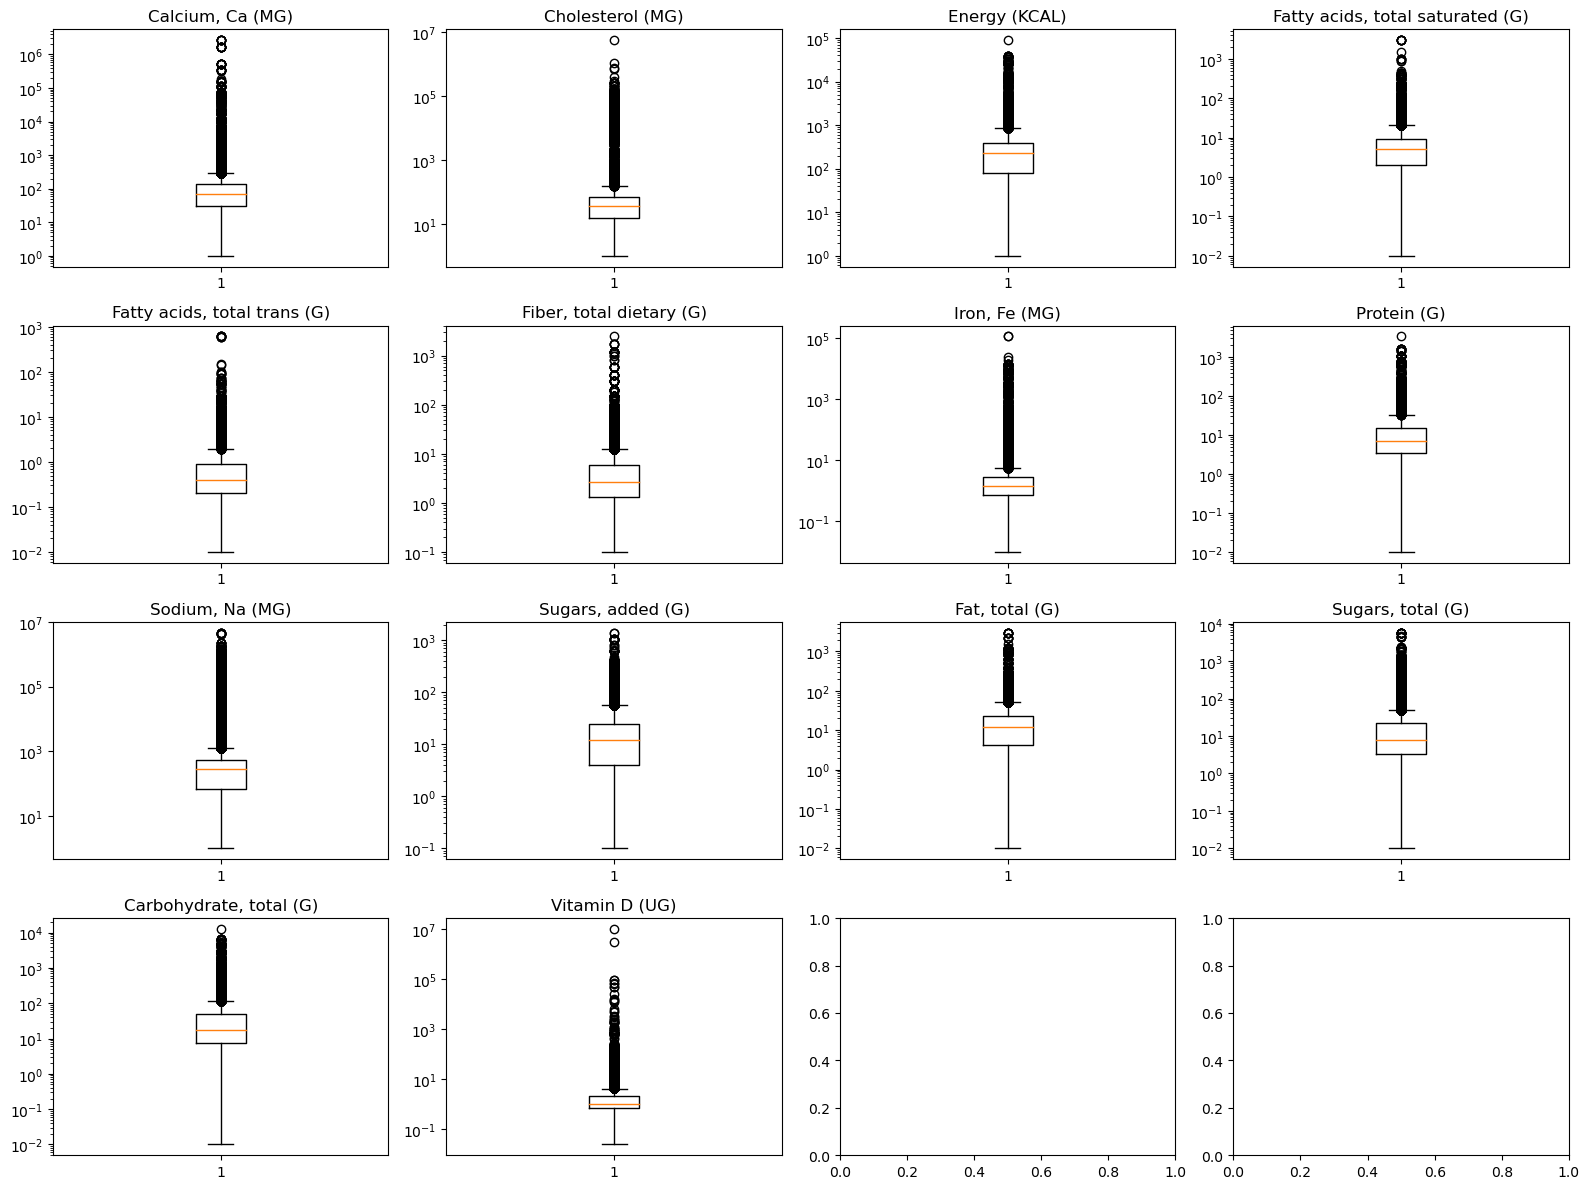

In [37]:
# boxplots of amounts for each nutrient column
fig, ax = plt.subplots(4,4, figsize=(16,12))
axs = ax.ravel()

for i, col in enumerate(unstacked.columns):
    cond = unstacked[col] > 0
    axs[i].boxplot(unstacked.loc[cond, col])
    axs[i].set_title(col)
    axs[i].set_yscale('log')
    
plt.tight_layout()

In [38]:
# are certain entries off by a few decimal places?
unstacked.describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,9.625830e+05,9.755570e+05,1.082694e+06,986751.000000,960621.000000,970203.000000,958969.000000,1.092775e+06,1.089016e+06,290637.000000,1.082176e+06,1.096692e+06,1.096692e+06,1.030280e+05
mean,1.632056e+02,8.433967e+01,2.479193e+02,4.843044,0.033776,2.755580,3.317364,9.294439e+00,7.047430e+02,12.606849,1.210072e+01,1.183255e+01,2.683399e+01,1.355076e+02
std,8.702623e+03,6.135103e+03,3.120104e+02,10.333876,1.845015,7.709326,195.800330,1.380447e+01,1.998574e+04,19.885927,1.803847e+01,3.173848e+01,4.811086e+01,3.324608e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,0.000000e+00,7.100000e+01,0.000000,0.000000,0.000000,0.000000,2.350000e+00,4.400000e+01,0.000000,3.800000e-01,8.300000e-01,5.000000e+00,0.000000e+00
50%,4.700000e+01,4.000000e+00,2.210000e+02,2.540000,0.000000,1.200000,0.910000,5.880000e+00,2.420000e+02,6.500000,7.060000e+00,4.290000e+00,1.500000e+01,6.250000e-01
75%,1.180000e+02,4.000000e+01,3.930000e+02,7.140000,0.000000,3.600000,2.220000,1.364000e+01,5.040000e+02,20.000000,1.964000e+01,1.642000e+01,4.412000e+01,1.250000e+00
max,2.666667e+06,5.500000e+06,9.000000e+04,3000.000000,615.380000,2468.900000,116071.430000,3.400000e+03,4.687500e+06,1400.000000,3.000000e+03,5.800000e+03,1.270000e+04,1.025641e+07


In [39]:
# sum of main constituents of food shouldn't exceed 100g, maybe sum to less than 100g due to water content
# define function to calculate sums using total carbohydrates and total sugars, add to df
def calc_cfpsfp(df):
    # sum carbohydrates, fats, proteins of each item
    df['cfp'] = df['Carbohydrate, total (G)'].fillna(0) \
        + df['Fat, total (G)'].fillna(0) \
        + df['Protein (G)'].fillna(0)
    df['cfp'].round(decimals=2)

    # using sugar total instead of carb total in sum
    df['sfp'] = df['Sugars, total (G)'].fillna(0) \
        + df['Fat, total (G)'].fillna(0) \
        + df['Protein (G)'].fillna(0)
    df['sfp'].round(decimals=2)
    
    return df

In [40]:
# calculate cfp and sfp sums
unstacked = calc_cfpsfp(unstacked)

In [41]:
# take a look at cfp sums over 100
unstacked[unstacked['cfp'] > 100].describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG),cfp,sfp
count,8993.000000,9.382000e+03,10532.000000,9544.000000,9094.000000,9518.000000,8882.000000,10558.000000,1.049100e+04,3085.000000,10323.000000,10612.000000,10612.000000,976.000000,10612.000000,10612.000000
mean,718.384188,1.010687e+03,1147.308299,16.045825,0.355835,12.580164,12.228452,38.027496,2.719598e+03,80.300227,43.252678,104.855879,171.591704,34.006327,251.500458,184.764633
std,2140.323260,5.842498e+04,2439.405660,84.573721,11.079671,60.158445,161.100051,97.316692,5.671651e+04,119.980578,116.115642,271.954503,389.673619,38.231769,513.689960,377.698902
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000
25%,0.000000,0.000000e+00,500.000000,3.570000,0.000000,1.800000,1.200000,4.760000,1.390000e+02,17.900000,16.070000,14.290000,64.290000,0.043750,103.570000,71.160000
50%,71.000000,0.000000e+00,583.000000,8.930000,0.000000,5.900000,2.630000,10.710000,4.000000e+02,38.700000,27.780000,43.190000,80.000000,29.175000,116.660000,92.850000
75%,250.000000,6.100000e+01,1000.000000,14.600000,0.000000,10.700000,5.140000,28.570000,9.850000e+02,87.500000,46.430000,100.000000,143.497500,50.000000,243.750000,200.000000
max,60000.000000,5.500000e+06,90000.000000,3000.000000,600.000000,1730.000000,7142.860000,3400.000000,2.285714e+06,1400.000000,3000.000000,5800.000000,12700.000000,150.000000,19000.000000,7800.000000


In [42]:
# could be off due to rounding error when entering data
# divide rows to rescale nutrient values based on cfp values
cond = unstacked['cfp'] > 100
factor = unstacked.loc[cond, 'cfp'] / 100
unstacked[cond] = unstacked[cond].divide(factor, axis=0)
# note changes
unstacked.loc[cond, 'changes'] = 1

# recalculate cfp and sfp
unstacked = calc_cfpsfp(unstacked)

unstacked.describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG),cfp,sfp,changes
count,9.625830e+05,975557.000000,1.082694e+06,986751.000000,960621.000000,970203.000000,958969.000000,1.092775e+06,1.089016e+06,290637.000000,1.082176e+06,1.096692e+06,1.096692e+06,1.030280e+05,1.096692e+06,1.096692e+06,10612.0
mean,1.583950e+02,77.634766,2.413630e+02,4.764871,0.031465,2.684657,3.264467,9.059801e+00,6.969168e+02,12.135120,1.189801e+01,1.118083e+01,2.580184e+01,1.352481e+02,4.656981e+01,3.194880e+01,1.0
std,8.700086e+03,2488.391374,1.793538e+02,6.110379,1.504787,4.897924,195.730848,9.686172e+00,1.986223e+04,14.432072,1.383316e+01,1.491045e+01,2.572049e+01,3.324608e+04,3.308434e+01,2.417495e+01,0.0
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,8.000000e+00,0.000000,7.100000e+01,0.000000,0.000000,0.000000,0.000000,2.350000e+00,4.400000e+01,0.000000,3.800000e-01,8.300000e-01,5.000000e+00,0.000000e+00,1.630000e+01,1.125000e+01,1.0
50%,4.700000e+01,4.000000,2.210000e+02,2.500000,0.000000,1.200000,0.910000,5.880000e+00,2.420000e+02,6.500000,7.060000e+00,4.290000e+00,1.500000e+01,6.250000e-01,4.000000e+01,2.600000e+01,1.0
75%,1.180000e+02,40.000000,3.930000e+02,7.140000,0.000000,3.500000,2.220000,1.364000e+01,5.000000e+02,20.000000,1.944000e+01,1.641000e+01,4.400000e+01,1.250000e+00,8.444000e+01,5.000000e+01,1.0
max,2.666667e+06,877526.356390,3.268000e+03,447.620000,615.380000,2468.900000,116071.430000,1.000000e+02,4.687500e+06,261.500000,1.000000e+02,5.333300e+02,1.000000e+02,1.025641e+07,1.000000e+02,5.333300e+02,1.0


In [43]:
# take a look at sfp values over 100
unstacked[unstacked['sfp'] > 100].describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG),cfp,sfp,changes
count,182.000000,192.000000,218.000000,208.000000,171.000000,204.000000,182.000000,221.000000,220.000000,43.000000,214.000000,221.000000,221.000000,10.000000,221.000000,221.000000,99.0
mean,95.464778,29.175259,522.482086,9.266657,0.648305,3.867203,3.022614,18.106715,1127.955199,34.468771,29.907595,87.702517,36.124392,3.403261,83.191403,134.769528,1.0
std,142.483346,54.492115,261.623063,9.617150,3.010946,4.600323,3.995451,23.375234,5279.856369,30.698194,24.438275,85.880856,32.197385,8.101894,24.605213,70.308321,0.0
min,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.670000,100.000000,1.0
25%,0.000000,0.000000,350.000000,3.999832,0.000000,0.000000,0.000000,2.940000,45.454545,6.700000,7.999664,47.221065,0.157376,0.000000,66.670000,100.000000,1.0
50%,67.000000,0.000000,500.000000,6.670000,0.000000,2.749771,1.710000,13.330000,244.021952,33.330556,32.290254,81.818182,33.090000,0.000000,97.630000,111.111111,1.0
75%,133.352669,25.450000,666.562962,13.337689,0.000000,6.626843,3.600000,20.000000,527.666667,60.000000,46.430000,110.000000,57.580000,0.000000,100.000000,132.500000,1.0
max,1290.759642,214.000000,1427.445417,48.167415,21.876094,18.200000,15.910000,92.000336,39600.000000,112.900000,92.064583,533.330000,100.000000,25.000000,100.000000,533.330000,1.0


In [44]:
# divide rows to rescale nutrient values based on sfp values
cond = unstacked['sfp'] > 100
factor = unstacked.loc[cond, 'sfp'] / 100
unstacked[cond] = unstacked[cond].divide(factor, axis=0)
unstacked.loc[cond, 'changes'] = 1

# recalculate cfp and sfp
unstacked = calc_cfpsfp(unstacked)

unstacked.describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG),cfp,sfp,changes
count,9.625830e+05,975557.000000,1.082694e+06,986751.000000,960621.000000,970203.000000,958969.000000,1.092775e+06,1.089016e+06,290637.000000,1.082176e+06,1.096692e+06,1.096692e+06,1.030280e+05,1.096692e+06,1.096692e+06,10734.0
mean,1.583917e+02,77.634089,2.413451e+02,4.764513,0.031464,2.684473,3.264400,9.059478e+00,6.968625e+02,12.134480,1.189714e+01,1.117500e+01,2.580071e+01,1.352481e+02,4.656750e+01,3.194179e+01,1.0
std,8.700086e+03,2488.391377,1.793146e+02,6.109295,1.504787,4.897688,195.730847,9.685932e+00,1.986215e+04,14.429784,1.383121e+01,1.484393e+01,2.571957e+01,3.324608e+04,3.308297e+01,2.412963e+01,0.0
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,8.000000e+00,0.000000,7.100000e+01,0.000000,0.000000,0.000000,0.000000,2.350000e+00,4.400000e+01,0.000000,3.800000e-01,8.300000e-01,5.000000e+00,0.000000e+00,1.630000e+01,1.125000e+01,1.0
50%,4.700000e+01,4.000000,2.210000e+02,2.500000,0.000000,1.200000,0.910000,5.880000e+00,2.420000e+02,6.500000,7.060000e+00,4.290000e+00,1.500000e+01,6.250000e-01,4.000000e+01,2.600000e+01,1.0
75%,1.180000e+02,40.000000,3.930000e+02,7.140000,0.000000,3.500000,2.220000,1.364000e+01,5.000000e+02,20.000000,1.944000e+01,1.641000e+01,4.400000e+01,1.250000e+00,8.444000e+01,5.000000e+01,1.0
max,2.666667e+06,877526.356390,3.268000e+03,447.620000,615.380000,2468.900000,116071.430000,1.000000e+02,4.687500e+06,261.500000,1.000000e+02,1.000000e+02,1.000000e+02,1.025641e+07,1.000000e+02,1.000000e+02,1.0


In [45]:
# drop extra cfp, sfp, changes columns
unstacked = unstacked.iloc[:, :14]

In [46]:
# conversion errors in columns with mg units?
# cholesterol should be around single digits to a few hundred mg
unstacked[unstacked['Cholesterol (MG)'] > 2000].describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,739.000000,884.000000,869.000000,830.000000,789.000000,744.000000,758.000000,875.000000,8.690000e+02,254.000000,871.000000,884.000000,884.000000,88.000000
mean,143.926441,57673.065524,275.936801,8.506013,0.069214,1.279195,1.240638,13.017167,8.775571e+04,11.109257,16.718642,8.939491,18.404912,1.433807
std,213.180476,59289.263407,139.883623,8.319746,0.481632,2.700753,1.671001,9.156250,2.645940e+05,11.501058,11.932560,12.588912,20.168022,3.171046
min,0.000000,2071.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,20000.000000,161.000000,2.335000,0.000000,0.000000,0.000000,4.467477,1.580000e+02,0.300000,6.065000,0.000000,2.922500,0.125000
50%,71.000000,45348.000000,257.000000,7.060000,0.000000,0.000000,0.850000,11.630000,5.770000e+02,9.200000,15.790000,2.220000,9.980000,0.425000
75%,125.000000,80357.000000,378.000000,14.233345,0.000000,1.400000,1.439212,20.689322,1.196068e+03,19.300000,25.000000,17.500000,28.920000,1.050000
max,1250.000000,877526.356390,733.000000,110.710000,7.620000,34.600000,20.000000,62.067967,1.720930e+06,51.200000,53.570000,56.410000,71.430000,14.125000


In [47]:
# divide values of column over a certain threshold by 1000
def divideby1000(df, column='', threshold=0):
    # bool indicating rows to be changed
    cond = df[column] > 2000
    # divide rows of column by 1000
    df.loc[cond, column] = df.loc[cond, column] / 1000
    return df

In [48]:
# possible error in unit conversion, divide unusually high values by 1000
unstacked = divideby1000(unstacked, column='Cholesterol (MG)', threshold=2000)
unstacked.describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,9.625830e+05,975557.000000,1.082694e+06,986751.000000,960621.000000,970203.000000,958969.000000,1.092775e+06,1.089016e+06,290637.000000,1.082176e+06,1.096692e+06,1.096692e+06,1.030280e+05
mean,1.583917e+02,25.425958,2.413451e+02,4.764513,0.031464,2.684473,3.264400,9.059478e+00,6.968625e+02,12.134480,1.189714e+01,1.117500e+01,2.580071e+01,1.352481e+02
std,8.700086e+03,41.812425,1.793146e+02,6.109295,1.504787,4.897688,195.730847,9.685932e+00,1.986215e+04,14.429784,1.383121e+01,1.484393e+01,2.571957e+01,3.324608e+04
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,0.000000,7.100000e+01,0.000000,0.000000,0.000000,0.000000,2.350000e+00,4.400000e+01,0.000000,3.800000e-01,8.300000e-01,5.000000e+00,0.000000e+00
50%,4.700000e+01,4.000000,2.210000e+02,2.500000,0.000000,1.200000,0.910000,5.880000e+00,2.420000e+02,6.500000,7.060000e+00,4.290000e+00,1.500000e+01,6.250000e-01
75%,1.180000e+02,40.000000,3.930000e+02,7.140000,0.000000,3.500000,2.220000,1.364000e+01,5.000000e+02,20.000000,1.944000e+01,1.641000e+01,4.400000e+01,1.250000e+00
max,2.666667e+06,1750.000000,3.268000e+03,447.620000,615.380000,2468.900000,116071.430000,1.000000e+02,4.687500e+06,261.500000,1.000000e+02,1.000000e+02,1.000000e+02,1.025641e+07


In [49]:
# sodium should be under a few 10,000 mg
unstacked[unstacked['Sodium, Na (MG)'] > 30000].describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,662.000000,743.000000,857.000000,775.000000,715.0,738.000000,622.000000,869.000000,8.780000e+02,255.000000,855.000000,878.000000,878.000000,59.000000
mean,457.985000,41.493721,263.073882,6.529439,0.0,4.221380,47.766980,10.522427,4.131907e+05,13.126004,14.565711,9.935452,23.877082,4.342627
std,6383.128658,64.685218,172.664707,7.963154,0.0,9.513368,402.549329,10.834292,5.647870e+05,12.056273,13.020714,13.162977,23.264062,5.369759
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.100000e+04,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,106.000000,1.210000,0.0,0.000000,0.000000,2.920000,6.470600e+04,1.100000,2.280000,0.000000,3.570000,0.125000
50%,57.000000,13.000000,253.000000,3.570000,0.0,1.600000,1.030000,7.140000,2.625000e+05,11.200000,11.270000,3.570000,17.265000,0.400000
75%,118.000000,71.000000,417.000000,10.100000,0.0,5.700000,2.160000,16.670000,5.941180e+05,20.050000,25.000000,16.470000,41.287500,10.725000
max,116279.000000,877.526356,714.000000,115.380000,0.0,200.000000,3571.430000,64.520000,4.687500e+06,58.800000,75.000000,64.710000,90.240000,15.300000


In [50]:
# possible error in unit conversion, divide unusually high values by 1000
unstacked = divideby1000(unstacked, column='Sodium, Na (MG)', threshold=30000)
unstacked.describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,9.625830e+05,975557.000000,1.082694e+06,986751.000000,960621.000000,970203.000000,958969.000000,1.092775e+06,1.089016e+06,290637.000000,1.082176e+06,1.096692e+06,1.096692e+06,1.030280e+05
mean,1.583917e+02,25.425958,2.413451e+02,4.764513,0.031464,2.684473,3.264400,9.059478e+00,3.252607e+02,12.134480,1.189714e+01,1.117500e+01,2.580071e+01,1.352481e+02
std,8.700086e+03,41.812425,1.793146e+02,6.109295,1.504787,4.897688,195.730847,9.685932e+00,3.615759e+02,14.429784,1.383121e+01,1.484393e+01,2.571957e+01,3.324608e+04
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,0.000000,7.100000e+01,0.000000,0.000000,0.000000,0.000000,2.350000e+00,3.900000e+01,0.000000,3.800000e-01,8.300000e-01,5.000000e+00,0.000000e+00
50%,4.700000e+01,4.000000,2.210000e+02,2.500000,0.000000,1.200000,0.910000,5.880000e+00,2.330000e+02,6.500000,7.060000e+00,4.290000e+00,1.500000e+01,6.250000e-01
75%,1.180000e+02,40.000000,3.930000e+02,7.140000,0.000000,3.500000,2.220000,1.364000e+01,4.840000e+02,20.000000,1.944000e+01,1.641000e+01,4.400000e+01,1.250000e+00
max,2.666667e+06,1750.000000,3.268000e+03,447.620000,615.380000,2468.900000,116071.430000,1.000000e+02,4.687500e+03,261.500000,1.000000e+02,1.000000e+02,1.000000e+02,1.025641e+07


In [51]:
# iron should be single digit mg
unstacked[unstacked['Iron, Fe (MG)'] > 1000].describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,161.000000,188.000000,197.000000,196.000000,172.000000,161.000000,212.000000,209.000000,209.000000,90.000000,200.000000,212.000000,212.000000,24.000000
mean,2055.331294,23.516495,272.907947,3.358669,0.006533,4.304961,6279.976788,10.668829,315.491874,17.545318,12.561514,15.364791,32.504821,0.944792
std,9273.470101,45.917998,176.060532,3.871633,0.085673,6.071552,11589.465484,8.396147,286.235449,17.267905,14.739320,18.147531,29.809401,1.926559
min,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,1011.235955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,116.000000,0.000000,0.000000,0.700000,1714.290000,3.170000,67.000000,0.000000,0.000000,0.000000,3.570000,0.000000
50%,36.000000,0.000000,243.000000,2.500000,0.000000,2.600000,3571.430000,8.570000,309.524000,16.300000,9.820000,4.760000,26.785000,0.000000
75%,71.000000,50.000000,397.000000,5.462500,0.000000,4.700000,7142.860000,17.860000,446.000000,34.200000,17.140000,31.250000,59.595000,0.137500
max,55357.000000,375.000000,633.000000,21.430000,1.123596,26.200000,116071.430000,26.790000,1667.000000,54.300000,50.000000,77.500000,92.500000,5.275000


In [52]:
# possible error in unit conversion, divide unusually high values by 1000
unstacked = divideby1000(unstacked, column='Iron, Fe (MG)', threshold=1000)
unstacked.describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,9.625830e+05,975557.000000,1.082694e+06,986751.000000,960621.000000,970203.000000,958969.000000,1.092775e+06,1.089016e+06,290637.000000,1.082176e+06,1.096692e+06,1.096692e+06,1.030280e+05
mean,1.583917e+02,25.425958,2.413451e+02,4.764513,0.031464,2.684473,1.991502,9.059478e+00,3.252607e+02,12.134480,1.189714e+01,1.117500e+01,2.580071e+01,1.352481e+02
std,8.700086e+03,41.812425,1.793146e+02,6.109295,1.504787,4.897688,14.987418,9.685932e+00,3.615759e+02,14.429784,1.383121e+01,1.484393e+01,2.571957e+01,3.324608e+04
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,0.000000,7.100000e+01,0.000000,0.000000,0.000000,0.000000,2.350000e+00,3.900000e+01,0.000000,3.800000e-01,8.300000e-01,5.000000e+00,0.000000e+00
50%,4.700000e+01,4.000000,2.210000e+02,2.500000,0.000000,1.200000,0.910000,5.880000e+00,2.330000e+02,6.500000,7.060000e+00,4.290000e+00,1.500000e+01,6.250000e-01
75%,1.180000e+02,40.000000,3.930000e+02,7.140000,0.000000,3.500000,2.220000,1.364000e+01,4.840000e+02,20.000000,1.944000e+01,1.641000e+01,4.400000e+01,1.250000e+00
max,2.666667e+06,1750.000000,3.268000e+03,447.620000,615.380000,2468.900000,1964.290000,1.000000e+02,4.687500e+03,261.500000,1.000000e+02,1.000000e+02,1.000000e+02,1.025641e+07


In [53]:
# calcium should be single digits to ~150 mg
unstacked[unstacked['Calcium, Ca (MG)'] > 5000].describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,2.310000e+02,203.000000,221.000000,210.000000,154.000000,191.000000,196.000000,230.000000,228.000000,62.000000,199.000000,231.000000,231.000000,36.000000
mean,1.998129e+05,21.078818,249.633484,3.907857,0.002597,4.060209,50.328723,10.663870,314.621364,11.958065,14.146633,13.293983,28.948918,28.409028
std,5.259054e+05,45.680701,161.762695,5.750703,0.022718,4.962405,203.227001,14.369698,465.188222,14.702799,13.647070,16.505977,27.717160,28.608423
min,5.194000e+03,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+04,0.000000,64.000000,0.000000,0.000000,0.000000,0.350000,3.120000,2.125000,0.000000,0.000000,0.000000,7.420000,31.250000
50%,2.320000e+04,0.000000,259.000000,0.850000,0.000000,1.400000,1.900000,6.670000,119.000000,4.050000,11.840000,7.140000,14.250000,31.250000
75%,7.656250e+04,35.000000,375.000000,5.560000,0.000000,7.500000,4.609375,12.500000,412.000000,15.600000,25.000000,18.750000,49.360000,31.250000
max,2.666667e+06,375.000000,556.000000,23.000000,0.200000,13.300000,1785.710000,74.070000,2000.000000,47.400000,37.500000,76.670000,100.000000,177.000000


In [54]:
# possible error in unit conversion, divide unusually high values by 1000
unstacked = divideby1000(unstacked, column='Calcium, Ca (MG)', threshold=5000)
unstacked.describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,962583.000000,975557.000000,1.082694e+06,986751.000000,960621.000000,970203.000000,958969.000000,1.092775e+06,1.089016e+06,290637.000000,1.082176e+06,1.096692e+06,1.096692e+06,1.030280e+05
mean,109.767248,25.425958,2.413451e+02,4.764513,0.031464,2.684473,1.991502,9.059478e+00,3.252607e+02,12.134480,1.189714e+01,1.117500e+01,2.580071e+01,1.352481e+02
std,188.672853,41.812425,1.793146e+02,6.109295,1.504787,4.897688,14.987418,9.685932e+00,3.615759e+02,14.429784,1.383121e+01,1.484393e+01,2.571957e+01,3.324608e+04
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000,0.000000,7.100000e+01,0.000000,0.000000,0.000000,0.000000,2.350000e+00,3.900000e+01,0.000000,3.800000e-01,8.300000e-01,5.000000e+00,0.000000e+00
50%,47.000000,4.000000,2.210000e+02,2.500000,0.000000,1.200000,0.910000,5.880000e+00,2.330000e+02,6.500000,7.060000e+00,4.290000e+00,1.500000e+01,6.250000e-01
75%,118.000000,40.000000,3.930000e+02,7.140000,0.000000,3.500000,2.220000,1.364000e+01,4.840000e+02,20.000000,1.944000e+01,1.641000e+01,4.400000e+01,1.250000e+00
max,2666.667000,1750.000000,3.268000e+03,447.620000,615.380000,2468.900000,1964.290000,1.000000e+02,4.687500e+03,261.500000,1.000000e+02,1.000000e+02,1.000000e+02,1.025641e+07


In [55]:
# vitamin d should be single digits to ~15 ug
unstacked[unstacked['Vitamin D (UG)'] > 700].describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,43.000000,43.000000,44.000000,44.000000,43.0,44.000000,43.000000,43.000000,46.000000,22.000000,47.000000,47.000000,47.000000,4.700000e+01
mean,253.162791,67.581395,251.431818,8.161364,0.0,2.175000,1.967209,13.963256,374.035326,13.913636,15.821489,9.780213,19.823617,2.928128e+05
std,376.332359,86.183700,170.445435,8.016583,0.0,4.851187,3.160326,12.117636,392.322156,15.786622,14.018347,15.334953,27.129198,1.545316e+06
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.140000e+02
25%,13.500000,2.000000,113.500000,0.590000,0.0,0.000000,0.360000,3.570000,87.250000,0.450000,2.415000,0.000000,0.000000,8.869500e+02
50%,67.000000,54.000000,190.500000,6.685000,0.0,0.000000,0.800000,12.280000,262.000000,6.550000,12.310000,1.790000,5.310000,1.980675e+03
75%,217.500000,89.000000,393.000000,16.517500,0.0,1.400000,1.750000,21.430000,577.000000,28.650000,28.570000,11.890000,27.730000,1.305000e+04
max,1250.000000,375.000000,571.000000,25.000000,0.0,17.900000,14.210000,46.430000,1786.000000,44.700000,46.670000,57.500000,86.840000,1.025641e+07


In [56]:
# possible error in unit conversion, divide unusually high values by 1000
unstacked = divideby1000(unstacked, column='Vitamin D (UG)', threshold=700)
# divide again, some values originally off by 10^6?
unstacked = divideby1000(unstacked, column='Vitamin D (UG)', threshold=700)
unstacked.describe()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
count,962583.000000,975557.000000,1.082694e+06,986751.000000,960621.000000,970203.000000,958969.000000,1.092775e+06,1.089016e+06,290637.000000,1.082176e+06,1.096692e+06,1.096692e+06,103028.000000
mean,109.767248,25.425958,2.413451e+02,4.764513,0.031464,2.684473,1.991502,9.059478e+00,3.252607e+02,12.134480,1.189714e+01,1.117500e+01,2.580071e+01,1.956531
std,188.672853,41.812425,1.793146e+02,6.109295,1.504787,4.897688,14.987418,9.685932e+00,3.615759e+02,14.429784,1.383121e+01,1.484393e+01,2.571957e+01,21.174593
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,8.000000,0.000000,7.100000e+01,0.000000,0.000000,0.000000,0.000000,2.350000e+00,3.900000e+01,0.000000,3.800000e-01,8.300000e-01,5.000000e+00,0.000000
50%,47.000000,4.000000,2.210000e+02,2.500000,0.000000,1.200000,0.910000,5.880000e+00,2.330000e+02,6.500000,7.060000e+00,4.290000e+00,1.500000e+01,0.625000
75%,118.000000,40.000000,3.930000e+02,7.140000,0.000000,3.500000,2.220000,1.364000e+01,4.840000e+02,20.000000,1.944000e+01,1.641000e+01,4.400000e+01,1.250000
max,2666.667000,1750.000000,3.268000e+03,447.620000,615.380000,2468.900000,1964.290000,1.000000e+02,4.687500e+03,261.500000,1.000000e+02,1.000000e+02,1.000000e+02,2000.000000


In [57]:
# round values to 2 decimal places
unstacked = unstacked.round(decimals=2)

In [58]:
# some nutrient values are abnormally high for 100g or 100ml portion --> no nutrient should be > 100g
# indicates inaccurate data entries
# eliminate items with nutrient value > 100g
for col in unstacked.columns:
    if '(G)' in col:
        # bool, indicates rows with values less than 100
        cond = unstacked[col] <= 100
    elif '(MG)' in col:
        # bool, indicates rows with values less than 100,000
        cond = unstacked[col] <= 1e5
    else:
        continue
    # keep rows that meet condition
    unstacked = unstacked[cond]

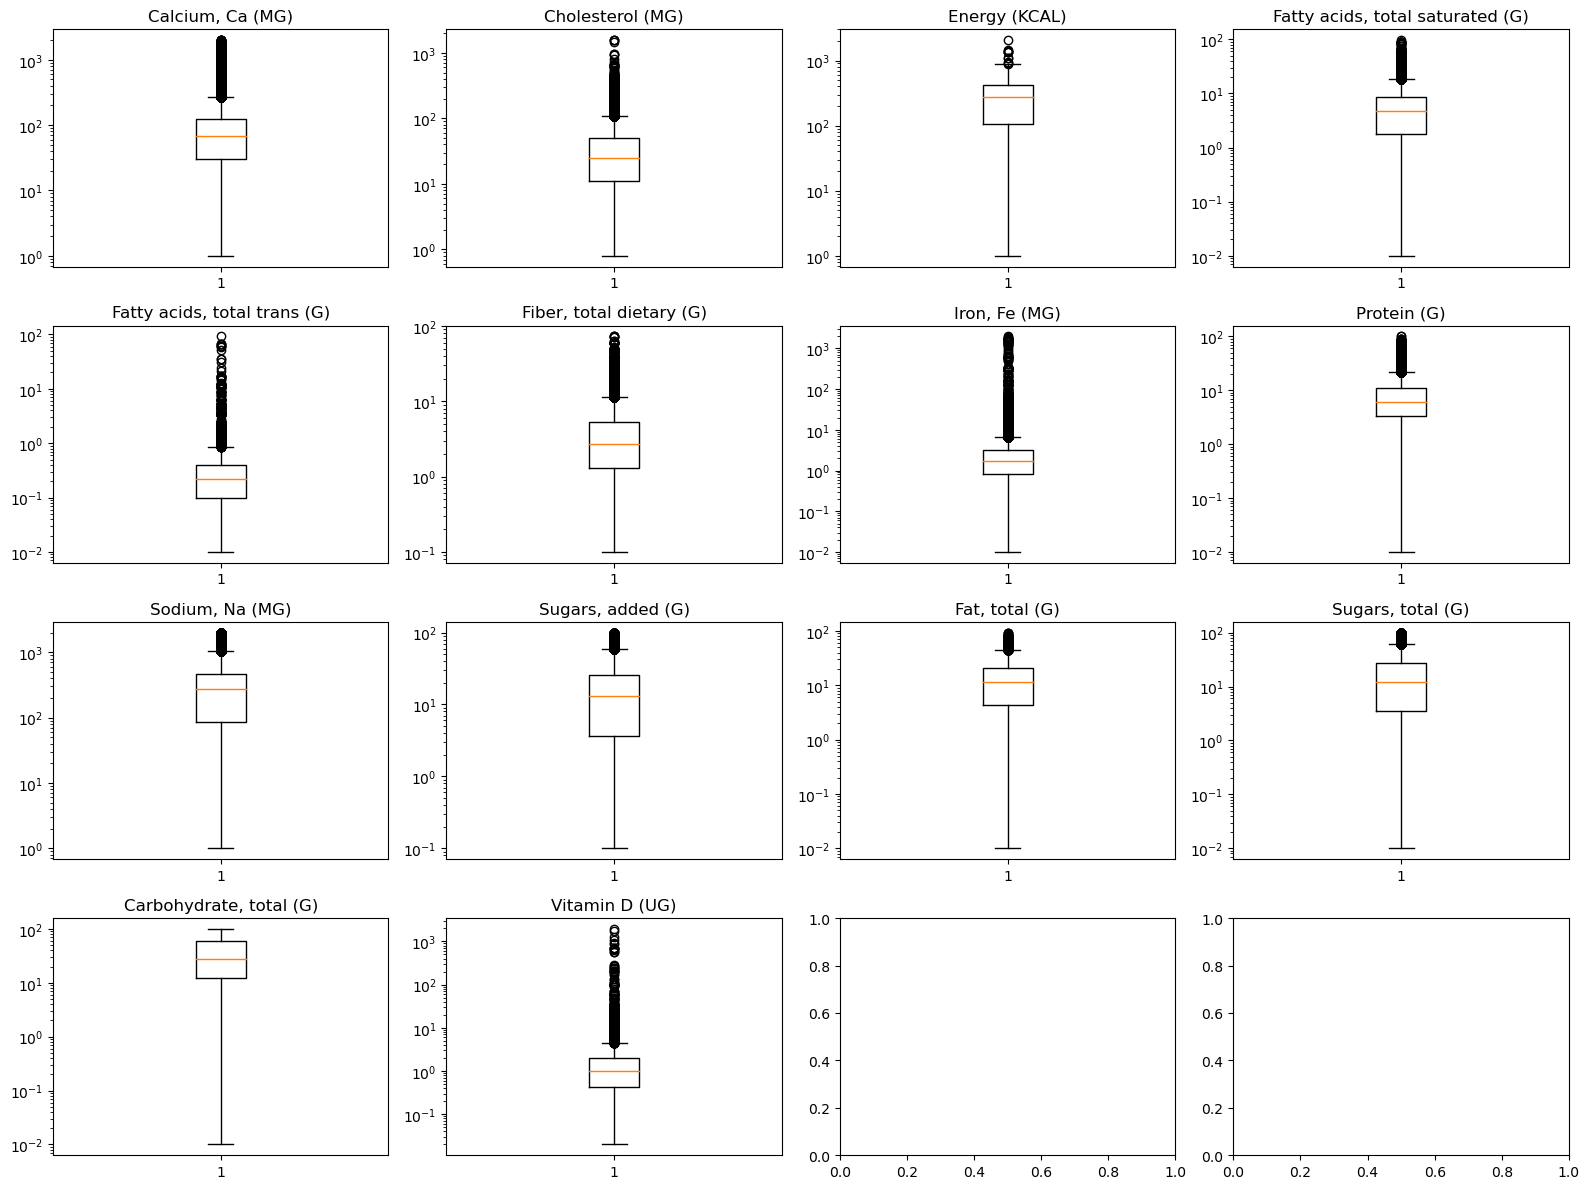

In [59]:
# plot values after dropping items with unreasonably high values
fig, ax = plt.subplots(4,4, figsize=(16,12))
axs = ax.ravel()

for i, col in enumerate(unstacked.columns):
    cond = unstacked[col] > 0
    axs[i].boxplot(unstacked.loc[cond, col])
    axs[i].set_title(col)
    axs[i].set_yscale('log')

plt.tight_layout()

In [60]:
print('shape after dropping rows with unreasonably large values:', unstacked.shape)

shape after dropping rows with unreasonably large values: (251689, 14)


In [61]:
unstacked.reset_index(inplace=True)

In [62]:
unstacked.to_csv('cleaned_food_nutrients.csv', index=False)